# Part 4: Effects of noise on quantum addition
---

Now, we can combine all the functions. Transform the circuit used in the quantum_sum to the gate basis and add noise. Use different levels of noise and analyze the results. 

- How does the noise affect the results? 
- Is there a way to decrease the effect of noise? 
- How does the number of gates used affect the results? 



The QFT based adder is first transpiled into the target basis. The resultant circuit is then exposed to noise. Functions defined earlier have been used.

In [1]:
import pennylane as qml
from pennylane import numpy as np
from helper_func import *
import matplotlib.pyplot as plt

Let's calculate the sum of 4 and 17. Change ```m``` and ```k``` here to calculate the sum of a different set of positive integers.

In [2]:
m = 4
k = 17
wires_m, wires_k, wires_solution = generate_wires(m, k)

print("wires_m:", wires_m)
print("wires_k:", wires_k)
print("wires_solution:", wires_solution)

wires_m: [0, 1, 2]
wires_k: [3, 4, 5, 6, 7]
wires_solution: [8, 9, 10, 11, 12]


In [3]:
def int_to_binary_ops(n, wires):
    binary = bin(n)[2:]
    binary = binary.zfill(len(wires))
    for i, bit in enumerate(binary):
        if bit == '1':
            qml.PauliX(wires=wires[i])

In [4]:
dev = qml.device("default.qubit", wires=wires_m + wires_k + wires_solution, shots=1)
n_wires = len(dev.wires) 

@qml.qnode(dev)
def quantum_sum(m, k, wires_m, wires_k, wires_solution):
    int_to_binary_ops(m, wires_m)
    int_to_binary_ops(k, wires_k)

    addition(wires_m, wires_k, wires_solution)

    return qml.sample(wires=wires_solution)

sample = quantum_sum(m, k, wires_m, wires_k, wires_solution)

print(f"The ket representation of the sum of {m} and {k} is {sample} which is equal to {int(''.join(map(str, sample)), 2)}.")

The ket representation of the sum of 4 and 17 is [1 0 1 0 1] which is equal to 21.


Hardware independent circuit:

(<Figure size 7600x1400 with 1 Axes>, <Axes: >)

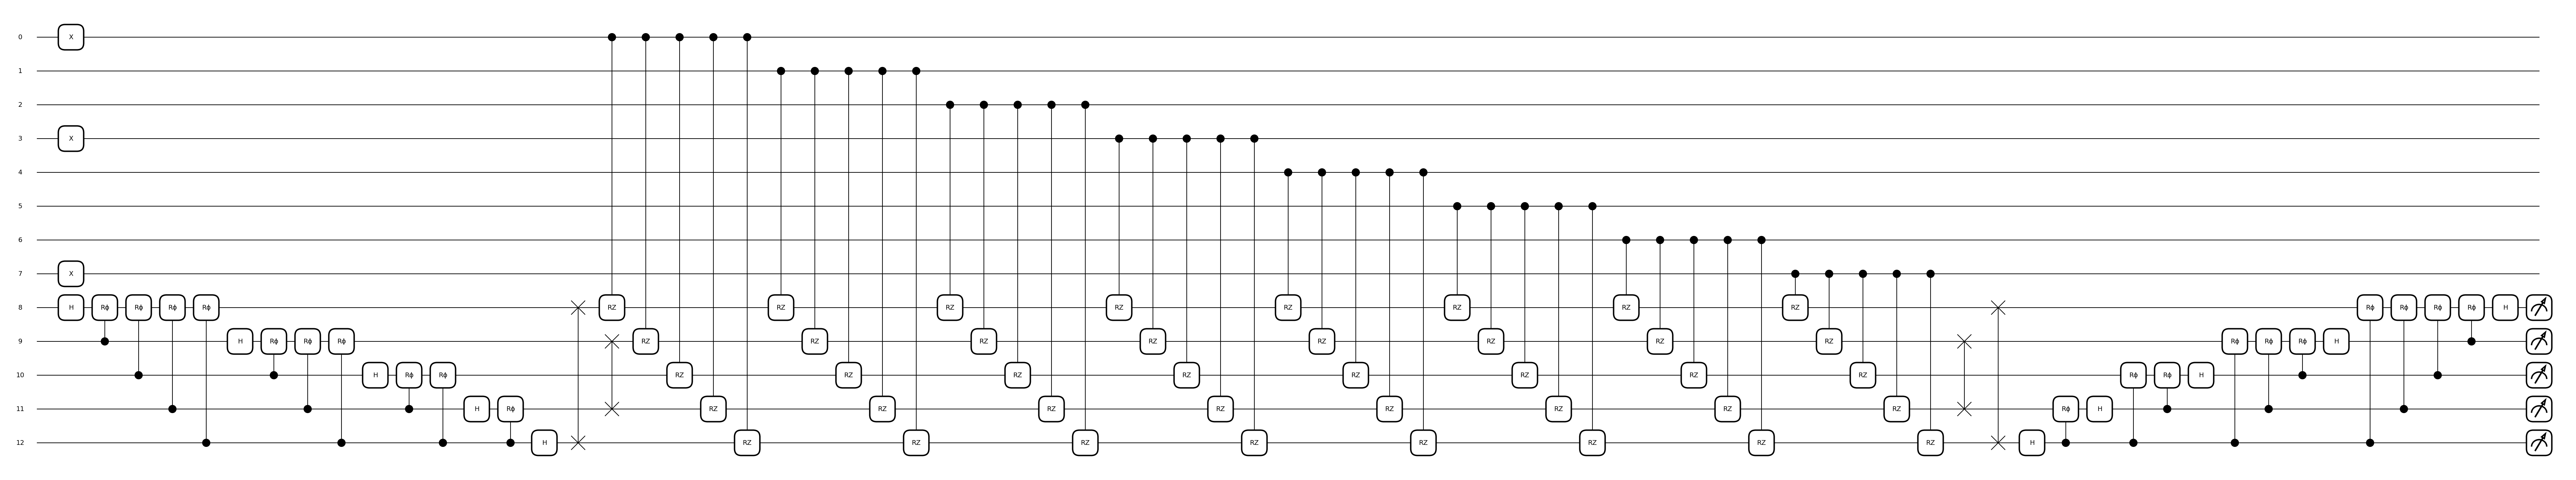

In [5]:
qml.draw_mpl(quantum_sum, show_all_wires=True)(m, k, wires_m, wires_k, wires_solution)

Decomposing the operations in the circuit to the target basis.

In [6]:
tape = quantum_sum.tape
ops = tape.operations
measurements = tape.measurements
decomposed_gates = decompose_pennylane_ops(ops)
decomposed_gates_list = get_decomposed_gates(decomposed_gates)
result = convert_gates_to_pennylane_circuit(decomposed_gates_list, return_type='state')
tape = qml.tape.QuantumTape(result.operations, measurements)
circuit = tape.circuit
# print(circuit) # print to see decomposed gates

Circuit with operations decomposed to the target basis:
(Image also in images folder)

(<Figure size 24800x1400 with 1 Axes>, <Axes: >)

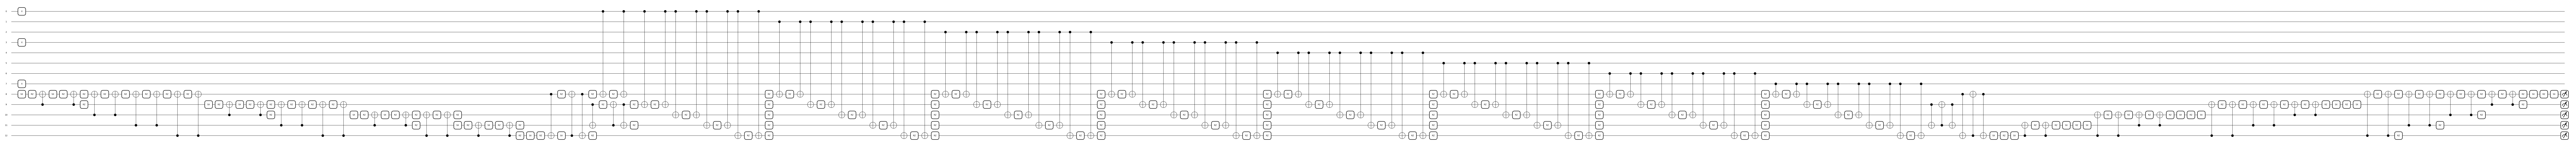

In [7]:
quantum_circuit = create_circuit_from_operations_measurements(result.operations, measurements, n_wires, dev)
compiled_circuit = qml.compile(quantum_circuit)
qml.draw_mpl(compiled_circuit)()

Sum from the decomposed circuit to verify with the hardware independent circuit:

In [8]:
print(f'{compiled_circuit()} which is equal to {int("".join(map(str, compiled_circuit())), 2)}.')

[1 0 1 0 1] which is equal to 21.


The decomposed circuit also produces the correct result, confirming that the gate decomposition into the target basis is accurate.

Now, introduce noise to the decomposed circuit:

In [9]:
alpha = 0.4
beta = 0.4

# The noise (Pauli errors) is decomposed to the target basis and then applied to the circuit
make_noisy_target_basis(alpha, beta, tape.operations)
noisy_tape = qml.tape.QuantumTape(tape.operations, measurements)
circuit = noisy_tape.circuit

Sum from the noisy circuit:

In [10]:
noisy_quantum_circuit = create_circuit_from_operations_measurements(noisy_tape.operations, measurements, n_wires, dev)
noisy_compiled_circuit = qml.compile(noisy_quantum_circuit)
noisy_sum = noisy_compiled_circuit()

print(f"{noisy_sum} which is equal to {int(''.join(map(str, noisy_sum)), 2)}.")

[0 1 0 1 0] which is equal to 10.


The noisy circuit has a very low probability of returning the correct result.

Generate a heatmap of fidelities between noiseless and noisy circuits for the sum $4 + 17$. (One run for each combination of $\alpha$ and $\beta$)

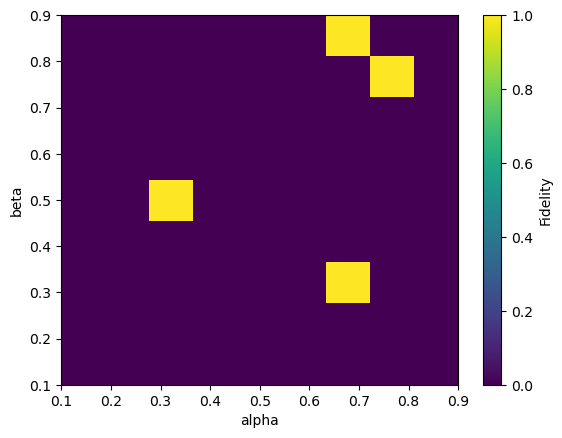

In [11]:
def fidelity_heatmap(m, k):
    param_range = np.linspace(0.1, 0.9, 9)
    results = np.zeros((len(param_range), len(param_range)))
    
    for i, param1 in enumerate(param_range):
        for j, param2 in enumerate(param_range):
            results[i, j] = noisy_decomposed_quantum_sum(m, k, param1, param2)
    
    plt.imshow(results, extent=[0.1, 0.9, 0.1, 0.9], origin='lower', aspect='auto', cmap='viridis')
    plt.colorbar(label='Fidelity')
    plt.xlabel('alpha')
    plt.ylabel('beta')
    plt.show()

fidelity_heatmap(4, 17)

Generate a heatmap of fidelities between noiseless and noisy circuits with increased number of gates ($10 + 17$). (One run for each combination of $\alpha$ and $\beta$)

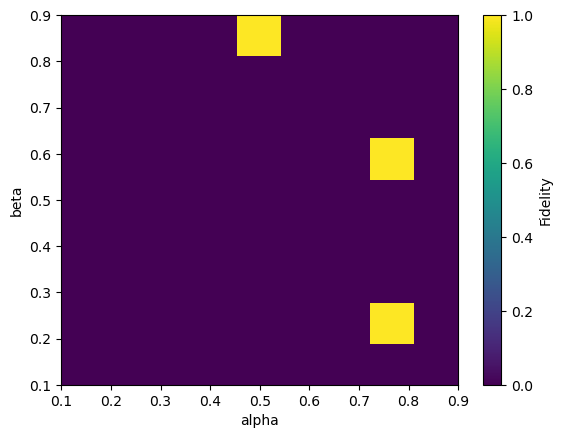

In [12]:
fidelity_heatmap(10, 17)

> How does the noise affect the results? 

The measurement outcomes from both noisy and noiseless circuits correspond to distinct basis states within a Hilbert space whose dimension is $2^{n}$, where $n$ is the number of qubits required to represent the correct result. These basis states are orthogonal and the fidelity between different outcomes is always 0.

However, in rare cases where the errors in the noisy circuit happen to cancel each other out, the measurement result matches that of the noiseless circuit, resulting in a perfect fidelity of 1. Note that this is random and each time the heatmap is run, the yellow squares appears elsewhere.

> Is there a way to decrease the effect of noise?

Quantum error-correcting codes can be implemented to detect and correct errors before decoding. However, the qubit overhead required for these codes increases significantly as the number of qubits in the circuit grows.

Since noise is introduced only after each operation, it is possible to reduce the circuit depth by developing more efficient decompositions and designing random circuits that can approximately simulate the original circuit.

> How does the number of gates used affect the results? 

As mentioned, the number of errors increases with the number of gates used, which can completely alter the outcome of the computation. However, the likelihood that some of those errors will cancel each other out still remains, although quite small.